In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

In [2]:
def f(x, y):
    return x**2 + np.exp(x) + y**2 - x*y

def gradient(x, y):
    return np.array([2*x + np.exp(x) - y, 
                     2*y - x])

def circle_projection(x):
    r = np.sqrt(1.5)
    return x / np.linalg.norm(x) * r if np.linalg.norm(x) > r else x

def square_projection(x):
    return np.array([min(max(x[0], -1), 1), min(max(x[1], -1), 1)])

def triangle_projection(x):
    B = np.array([1.5,-1])
    C = np.array([-1, 1.5])
    BC = -B + C
    proj_x = B + (((x - B) @ BC) / np.linalg.norm(BC)**2) * BC
    x, y = x
    if y > x - 2.5 and y < x + 2.5 and y > -x + 0.5:
        x, y = proj_x
    return np.array([min(max(x, -1), 1.5), min(max(y, -1), 1.5)])

def projected_gradient_descent_step(x, gamma, domain):
    xi = x - gamma * gradient(x[0], x[1])
    if domain == 'circle':
        return circle_projection(xi)
    elif domain == 'square':
        return square_projection(xi)
    elif domain == 'triangle':
        return triangle_projection(xi)
    else:
        print("Wrong domain.")

def PGD(x1, T, gamma, alpha, domain):
    x = x1
    xi = np.array([x1])
    for i in range(1, T):
        if alpha is not None: gamma = 2/(alpha*(i+1))
        x = projected_gradient_descent_step(x, gamma, domain)
        xi = np.append(xi, [x], axis=0)
    return xi

def plot_PGD(xi, x_min, domain, ax):
    
    x, y = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)

    ax.contourf(X,Y,f(X, Y))

    if domain == 'circle':
        theta = np.linspace(0, 2*np.pi, 100)
        r = np.sqrt(1.5)
        x = np.cos(theta) * r
        y = np.sin(theta) * r
    elif domain == 'square':
        x = np.array([-1, 1, 1, -1, -1])
        y = np.array([1, 1, -1, -1, 1])
    elif domain == 'triangle':
        x = np.array([-1, 1.5, -1, -1])
        y = np.array([-1, -1, 1.5, -1])

    ax.plot(x, y, color='black', label='domain')

    ax.plot(xi[:,0], xi[:,1], '.-r', label='PGD steps')
    ax.plot(xi[0,0], xi[0,1], '.g', label='start')
    ax.plot(xi[-1,0], xi[-1,1], '.', color='orange', label='end')
    ax.plot(x_min[0],x_min[1], '.b', label='minima')

    ax.set_title(f'Projected gradient descent with {domain} domain')
    ax.set_ylabel('y')
    ax.set_xlabel('x')

def plot_guarantees(xi, x_min, guarantee, T, ax, ver=None):
    values = []
    if ver == 1:
        for i in range(1, T+1):
            V = 1/i * np.sum(xi[:i], axis=0)
            values.append(f(V[0], V[1]) - f(x_min[0], x_min[1]))
        ax.hlines(guarantee, 1, T, linestyles='dashed', color='black', label="Guarantee")
    elif ver == 2:
        values = f(xi[:,0], xi[:,1]) - f(x_min[0], x_min[1])
        ax.plot(range(1,T+1), guarantee, '--', color='black', label="Guarantee")
    elif ver == 3:
        for i in range(1, T+1):
            V = 0
            for j in range(i):
                V += 2*j / (i*(i+1) * xi[j])
            values.append(f(V[0], V[1]) - f(x_min[0], x_min[1]))
        ax.hlines(guarantee, 1, T, linestyles='dashed', color='black', label="Guarantee")
    else: 
        print("Wrong version")
    
    ax.plot(range(1,T+1), values, '.-r', label="Left side inequality value")
    
    ax.set_ylabel("Value")
    ax.set_xlabel("Timesteps")
    ax.set_yscale('log')

In [3]:
x1 = np.array([-1, 1])
T = 11
beta = 9.52
alpha = 1.07
L = 14.67
x_min = np.array([-0.432563, -0.216281])
domains = ['circle', 'square', 'triangle']

Guarantees:

1. If $f$ is L-Lipschitz and $\gamma=\frac{\left\|x_{1}-x^{*}\right\|}{L \sqrt{T}}$ for some $T \in \mathbb{N}$, then

$$f\left(\frac{1}{T} \sum_{i=1}^{T} x_{i}\right)-f\left(x^{*}\right) \leq \frac{L\left\|x_{1}-x^{*}\right\|}{\sqrt{T}}$$


Our guarantee for final step is: 5.9364896569245476
Minima is at (-0.432563, -0.216281) with value: 0.7891770364033909

For circle domain left side inequality is: 1.0321992420877537
Final point is (-0.5059392713959698, 0.3841298984711082) with value 1.2008157122289824

For square domain left side inequality is: 1.1577968902705496
Final point is (-0.5283112513930427, 0.41020395507821267) with value 1.2536952432306214

For triangle domain left side inequality is: 1.1577968902705496
Final point is (-0.5283112513930427, 0.41020395507821267) with value 1.2536952432306214



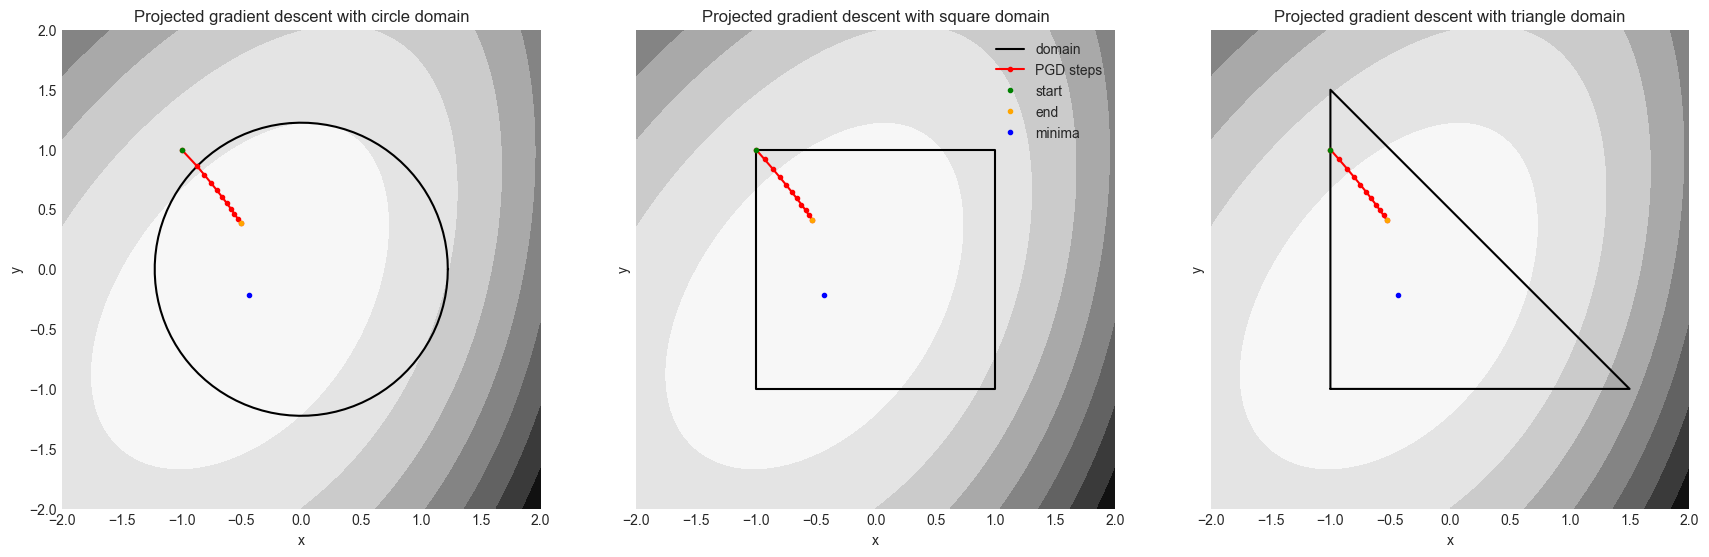

In [4]:
gamma = np.linalg.norm(x1 - x_min) / (L * np.sqrt(T))
guarantee = (L * np.linalg.norm(x1 - x_min)) / np.sqrt(T)

print(f'Our guarantee for final step is: {guarantee}')
print(f'Minima is at ({x_min[0]}, {x_min[1]}) with value: {f(x_min[0], x_min[1])}\n')

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(21,7))

for ax in axs:
    ax.set_box_aspect(1)

for i, domain in enumerate(domains):
    xi = PGD(x1, T, gamma, None, domain)
    plot_PGD(xi, x_min, domain, axs[i])
    V = 1/T * np.sum(xi, axis=0)
    left_side_inequality = f(V[0], V[1]) - f(x_min[0], x_min[1])
    print(f'For {domain} domain left side inequality is: {left_side_inequality}')
    print(f'Final point is ({xi[-1,0]}, {xi[-1,1]}) with value {f(xi[-1,0], xi[-1,1])}\n')
    # plot_guarantees(xi, x_min, guarantee, T, axs[1][i], ver=1)      plotting guaranteees is inaccurate since guarantee and learning rate depend on T (only works for final step)

axs[1].legend()



2. If $f$ is $\beta$-smooth and $\gamma=\beta^{-1}$, then

$$f\left(x_{k}\right)-f\left(x^{*}\right) \leq \frac{3 \beta\left\|x_{1}-x^{*}\right\|^{2}+f\left(x_{1}\right)-f\left(x^{*}\right)}{k} .$$


Our guarantee for final step is: 4.954934865670379
Minima is at (-0.432563, -0.216281) with value: 0.7891770364033909

For circle domain left side inequality is: 0.015170821169835591
Final point is (-0.355701139323922, -0.08418420993529793) with value 0.8043478575732265

For square domain left side inequality is: 0.015170821169835591
Final point is (-0.355701139323922, -0.08418420993529793) with value 0.8043478575732265

For triangle domain left side inequality is: 0.015170821169835591
Final point is (-0.355701139323922, -0.08418420993529793) with value 0.8043478575732265



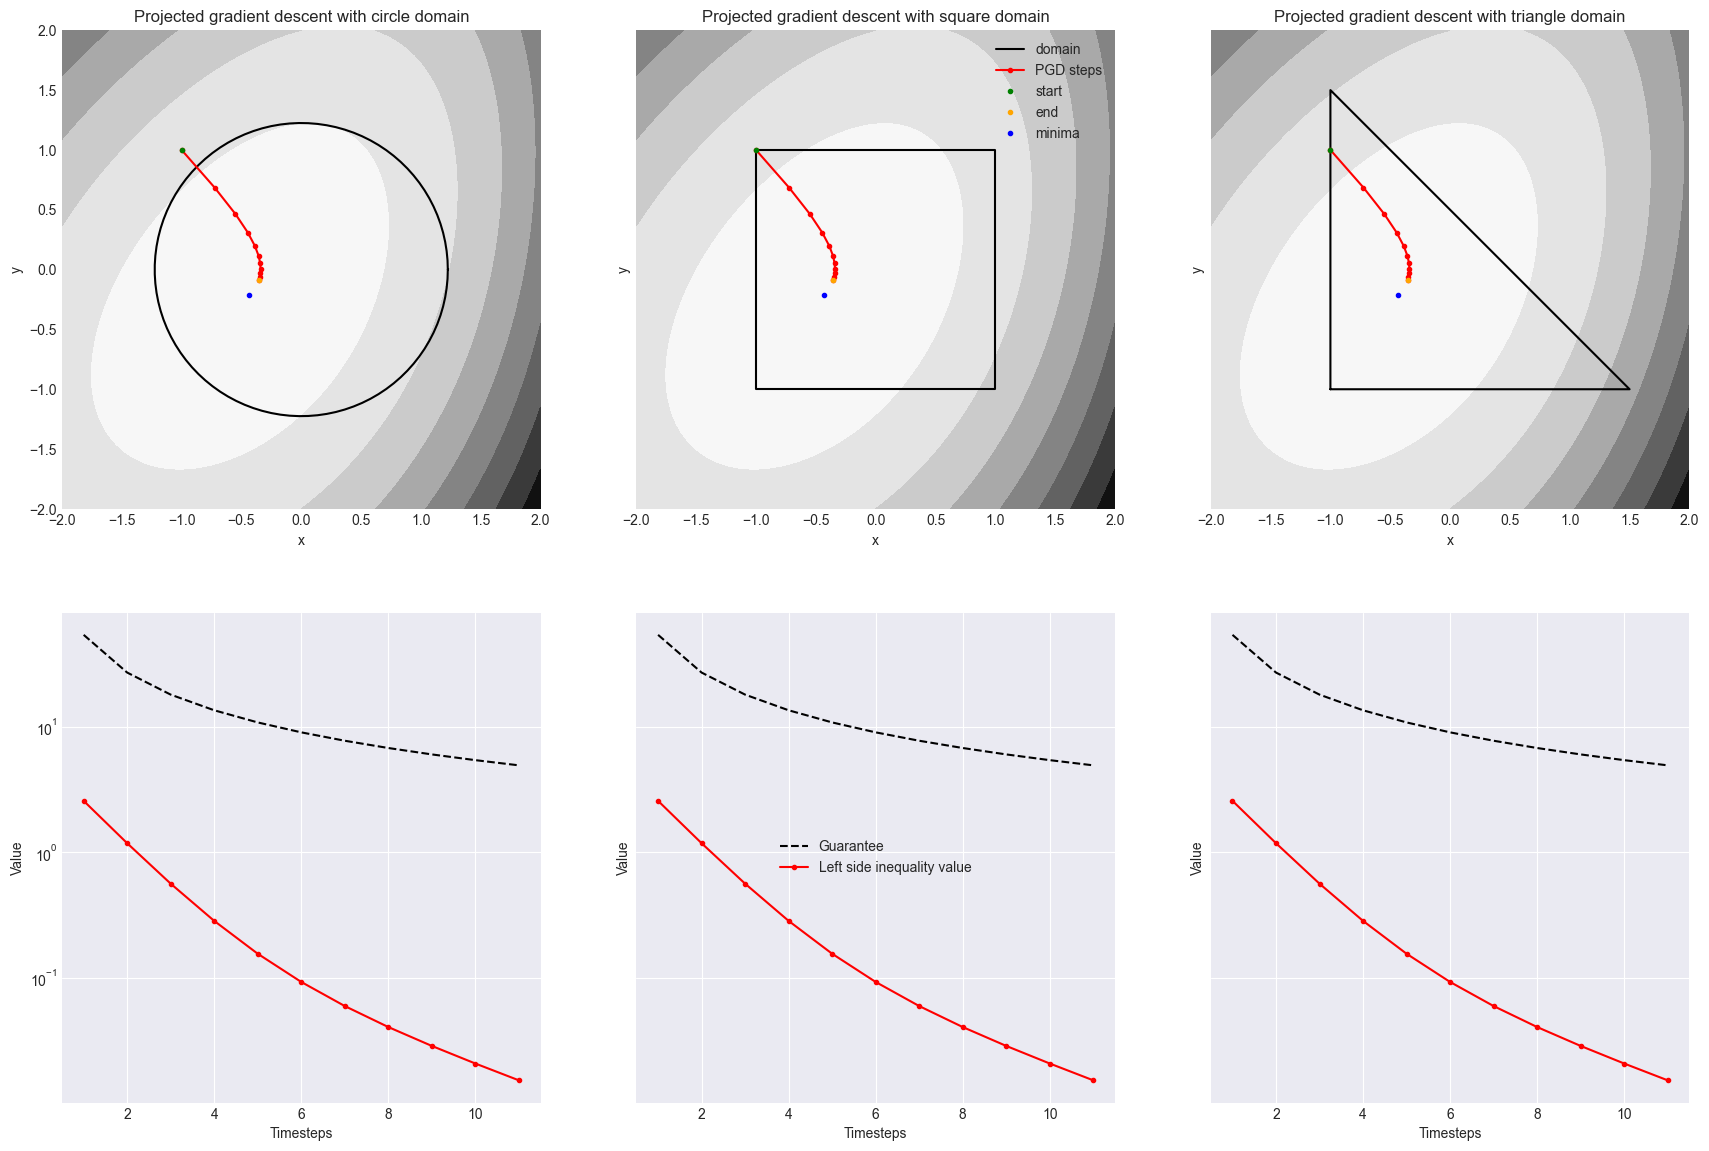

In [5]:
gamma = 1/beta
guarantee = (3*beta * np.linalg.norm(x1-x_min)**2 + f(x1[0] - x_min[0], x1[1] - x_min[1]) ) / range(1,12)
print(f'Our guarantee for final step is: {guarantee[-1]}')
print(f'Minima is at ({x_min[0]}, {x_min[1]}) with value: {f(x_min[0], x_min[1])}\n')

fig, axs = plt.subplots(2, 3, sharey='row', figsize=(21,14))

for ax in axs[0,:]:
    ax.set_box_aspect(1)

for i, domain in enumerate(domains):
    xi = PGD(x1, T, gamma, None, domain)
    plot_PGD(xi, x_min, domain, axs[0][i])
    plot_guarantees(xi, x_min, guarantee, T, axs[1][i], ver=2)
    left_side_inequality = f(xi[-1][0], xi[-1][1]) - f(x_min[0], x_min[1])
    print(f'For {domain} domain left side inequality is: {left_side_inequality}')
    print(f'Final point is ({xi[-1,0]}, {xi[-1,1]}) with value {f(xi[-1,0], xi[-1,1])}\n')

axs[0][1].legend()
axs[1][1].legend(loc='center')

3. If $f$ is $\alpha$-strongly convex and L-Lipschitz, and $\gamma_{k}=\frac{2}{\alpha(k+1)}$, then

$$f\left(\sum_{i=1}^{T} \frac{2 i}{T(T+1)} x_{i}\right)-f\left(x^{*}\right) \leq \frac{2 L^{2}}{\alpha(T+1)} .$$



Our guarantee for final step is: 33.52163551401869
Minima is at (-0.432563, -0.216281) with value: 0.7891770364033909

For circle domain left side inequality is: 0.006393683975671971
Final point is (-0.4340610328928463, -0.2183522691721731) with value 0.7891811949700759

For square domain left side inequality is: 0.012117883509103144
Final point is (-0.4275340340001535, -0.2093682899817477) with value 0.7892235690001002

For triangle domain left side inequality is: 0.01618627306487186
Final point is (-0.4253521952753984, -0.20635953857700837) with value 0.7892728374804305



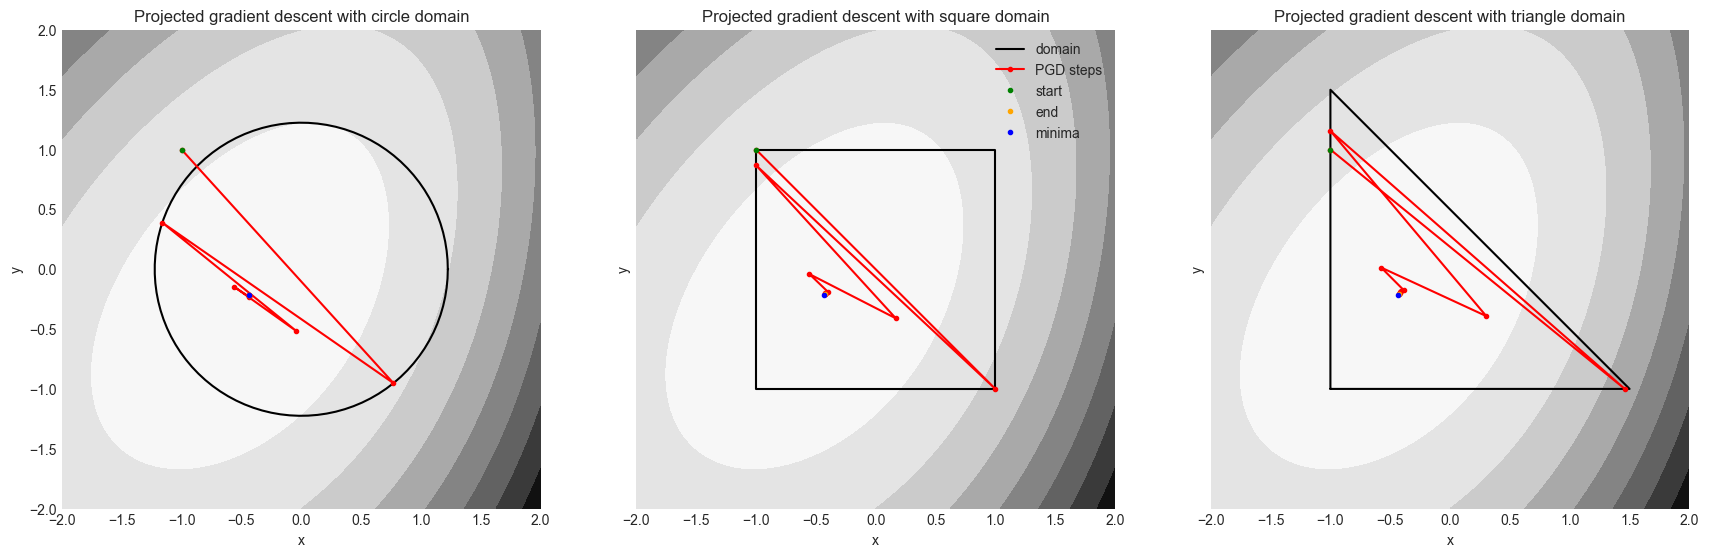

In [6]:
gamma = None # we change gamma in each iteration
guarantee = (2 * L**2) / (alpha * (T + 1))

print(f'Our guarantee for final step is: {guarantee}')
print(f'Minima is at ({x_min[0]}, {x_min[1]}) with value: {f(x_min[0], x_min[1])}\n')

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(21,7))

for ax in axs:
    ax.set_box_aspect(1)

for i, domain in enumerate(domains):
    xi = PGD(x1, T, gamma, alpha, domain)
    plot_PGD(xi, x_min, domain, axs[i])
    V = sum([(2*j / (T*(T+1))) * xi[j] for j in range(T)])
    left_side_inequality = f(V[0], V[1]) - f(x_min[0], x_min[1])
    print(f'For {domain} domain left side inequality is: {left_side_inequality}')
    print(f'Final point is ({xi[-1,0]}, {xi[-1,1]}) with value {f(xi[-1,0], xi[-1,1])}\n')
    # plot_guarantees(xi, x_min, guarantee, T, axs[1][i], ver=3)            plotting guaranteees is inaccurate since guarantee and learning rate depend on T

axs[1].legend()


We observe that the adaptive learning rate (third guarantee in this notebook) performs best out of three tested. It is similar based on the domain for all guarantees, but the adaptive learning rate performs slightly better on circular domain, since the points "jump" less.